In [1]:
import json
from collections import Counter
from string import punctuation
import os

import bz2
import regex
import re
from tqdm import tqdm
from scipy import sparse
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
import gensim
from gensim import corpora

from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np
import nltk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %pylab inline

tqdm.pandas()

In [2]:
responses = []
with open('banki_responses.json', 'r', encoding='utf-8') as f:
    for i, row in enumerate(tqdm(f)):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
len(responses)

201030it [00:28, 7050.98it/s]


153499

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [3]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [4]:
banki = pd.DataFrame(responses)
banki['datetime'] = pd.to_datetime(banki['datetime'])
banki.info()
banki

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   city                138325 non-null  object        
 1   rating_not_checked  153499 non-null  bool          
 2   title               153499 non-null  object        
 3   num_comments        153499 non-null  int64         
 4   bank_license        153498 non-null  object        
 5   author              153479 non-null  object        
 6   bank_name           153499 non-null  object        
 7   datetime            153499 non-null  datetime64[ns]
 8   text                153499 non-null  object        
 9   rating_grade        88658 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 10.7+ MB


,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки

In [5]:
city_cnt = Counter(banki['city'])
city_cnt.most_common(20)

[('г. Москва', 55354),
 (None, 15174),
 ('г. Санкт-Петербург', 14342),
 ('г. Екатеринбург', 2337),
 ('г. Новосибирск', 2300),
 ('г. Нижний Новгород', 1976),
 ('г. Ростов-на-Дону', 1891),
 ('г. Самара', 1731),
 ('г. Челябинск', 1507),
 ('г. Казань', 1440),
 ('г. Краснодар', 1262),
 ('г. Уфа', 1246),
 ('г. Красноярск', 1236),
 ('г. москва', 1217),
 ('г. Воронеж', 1210),
 ('г. Пермь', 1163),
 ('г. Волгоград', 1014),
 ('г. Омск', 989),
 ('г. Саратов', 933),
 ('г. Иркутск', 749)]

In [6]:
bank_cnt = Counter(banki['bank_name'])
bank_cnt.most_common(20)

[('Сбербанк России', 26327),
 ('Альфа-Банк', 10224),
 ('ВТБ 24', 8185),
 ('Русский Стандарт', 7943),
 ('Хоум Кредит Банк', 7549),
 ('Тинькофф Банк', 5387),
 ('Национальный Банк «Траст»', 4607),
 ('Ренессанс Кредит', 3849),
 ('Связной Банк', 3775),
 ('ОТП Банк', 3237),
 ('Восточный Экспресс Банк', 3138),
 ('Райффайзенбанк', 3057),
 ('Московский Кредитный Банк', 2944),
 ('Ситибанк', 2848),
 ('Авангард', 2733),
 ('Промсвязьбанк', 2586),
 ('ЮниКредит Банк', 2488),
 ('Банк Москвы', 2456),
 ('Ханты-Мансийский банк Открытие', 2158),
 ('МТС Банк', 1870)]

2. Постройте гистограмы длин слов в символах и в словах

In [7]:
# Добавляем столбцы с токенами

def get_tokens(text):
    return re.findall(r'[А-Яа-я]+', text.lower())
#     tokens = word_tokenize(text.lower())
#     return [token for token in tokens if token not in punctuation]

# banki['tokens'] = banki['text'].str.lower().str.findall(r'[А-Яа-я]+')
banki['tokens'] = banki['text'].progress_apply(get_tokens)
banki['tokens_count'] = banki['tokens'].str.len()
banki

100%|██████████| 153499/153499 [00:15<00:00, 10082.89it/s]


,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,tokens,tokens_count
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"[добрый, день, я, не, являюсь, клиентом, банка...",213
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"[доброго, дня, являюсь, держателем, зарплатной...",135
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"[здравствуйте, дублирую, свое, заявление, от, ...",83
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"[добрый, день, я, открыл, расчетный, счет, в, ...",121
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"[г, взяла, кредит, в, вашем, банке, заявленная...",291
...,...,...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,"[слишком, большой, банк, не, всегда, учитывает...",50
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0,"[вы, сами, виноваты, в, своих, проблемах, кром...",112
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,"[уважаемое, руководство, банка, овк, я, прожив...",786
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0,"[пробовала, оформить, товар, в, кредит, в, аль...",96


In [8]:
word_length_cnt = Counter()  # счетчик длин слов (ключ: длина слова, значение: кол-во слов такой длины)
word_cnt = Counter()  # счетчик уникальных слов (ключ: слово, значение: кол-во повторений)

# word_lengths = {}
# word_counts = {}

for words in tqdm(banki['tokens']):
    # для каждого слова вычисляем его длину
    word_length_cnt.update([len(word) for word in words])
    word_cnt.update(words)
    
#     for word in words:
#         word_length = len(word)
#         if word_length > 30:
#             print(word)
#         if word_length in word_lengths:
#             word_lengths[word_length] += 1
#         else:
#             word_lengths[word_length] = 1
#         
#         if word in word_counts:
#             word_counts[word] += 1
#         else:
#             word_counts[word] = 1

100%|██████████| 153499/153499 [00:10<00:00, 14683.66it/s]


In [9]:
word_length_cnt

Counter({6: 3791372,
         4: 2900976,
         1: 4515472,
         2: 3897962,
         7: 3144115,
         8: 2708775,
         5: 4370298,
         11: 909581,
         10: 1455175,
         9: 2379698,
         14: 202272,
         13: 375984,
         3: 4019032,
         16: 49893,
         12: 567720,
         15: 104531,
         17: 16664,
         19: 4090,
         20: 2061,
         26: 34,
         22: 865,
         18: 10617,
         23: 438,
         24: 1035,
         25: 95,
         21: 583,
         27: 10,
         29: 3,
         82: 1,
         39: 1,
         66: 1,
         34: 3,
         28: 2,
         32: 2,
         35: 1,
         30: 5,
         73: 1,
         40: 1,
         61: 1,
         45: 1,
         50: 1,
         80: 1})

In [10]:
word_cnt

Counter({'добрый': 18553,
         'день': 76552,
         'я': 577500,
         'не': 855335,
         'являюсь': 19699,
         'клиентом': 26246,
         'банка': 275906,
         'и': 1058997,
         'поручителем': 990,
         'по': 372769,
         'кредитному': 3067,
         'договору': 7736,
         'а': 233385,
         'также': 30498,
         'каким': 7322,
         'либо': 21006,
         'другим': 3968,
         'лицом': 1557,
         'письменно': 1220,
         'оформившим': 13,
         'отношения': 6815,
         'с': 464037,
         'банком': 40110,
         'поводу': 10199,
         'урегулирования': 622,
         'чьей': 278,
         'задолженности': 14972,
         'начиная': 1903,
         'марта': 10334,
         'года': 55746,
         'начали': 4829,
         'приходить': 3814,
         'бесконечные': 321,
         'письма': 5457,
         'из': 108632,
         'ооо': 5067,
         'примо': 2,
         'коллект': 9,
         'на': 707935,
         'м

In [11]:
list(banki[banki['text'].str.find('втечениенеделимыпередаемвашеделовслужбубезопасностимывамкредитнуюисториюиспортим') != -1]['text'])[0]

'Не прошло и полугода, как мне снова позвонили (см. http://www.banki.ru/services/responses/bank/index.php?a&a=&responseID=496447&login=yes)... На этот раз некий Сергей, как он представился, Александрович, а именно так он велел себя называть по причине возраста, во много раз превышающий мой, в категоричной форме требовал оплаты долга. Он даже готов был мне назвать сумму... опять. Уверен, что сумма долга, названная в четвертый раз, обязательно будет отличаться от всех, названных ранее... Так вот, Сергей Александрович убеждал оплатить меня долг на очень повышенных тонах, и мое общение ранее с другими сотрудниками МКПБ его не волнует. Так как перекрикивать его у меня желания не было, я попросил его его перезвонить в другой раз и в другом тоне.  Сергей Александрович перезвонил и сказав, что у него такой тембр голоса и что он всегда так говорит, решил прочитать мне лекцию о тех клиентах, с кем он уже работал, и которые после общения с ним все заплатили, и что мне лучше было бы с ними не встр

In [12]:
df = pd.DataFrame(word_length_cnt.items(), columns=['word_length', 'count']).sort_values(by='word_length').reset_index(drop=True)
df

,word_length,count
0,1,4515472
1,2,3897962
2,3,4019032
3,4,2900976
4,5,4370298
5,6,3791372
6,7,3144115
7,8,2708775
8,9,2379698
9,10,1455175


<AxesSubplot:xlabel='word_length'>

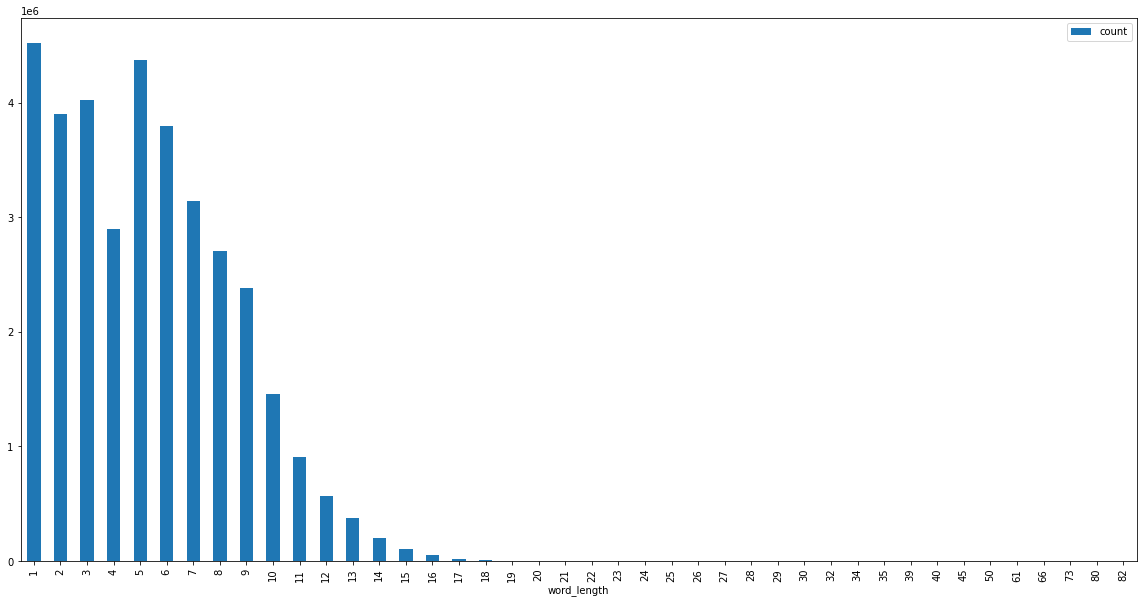

In [13]:
df.plot(kind='bar', x='word_length', y='count', figsize=(20, 10))

3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных

In [14]:
len(word_cnt)

265248

In [15]:
word_cnt.most_common(10)

[('в', 1330550),
 ('и', 1058997),
 ('не', 855335),
 ('на', 707935),
 ('что', 640057),
 ('я', 577500),
 ('с', 464037),
 ('по', 372769),
 ('мне', 320958),
 ('банка', 275906)]

In [16]:
# поиск в множестве выполняется намного быстрее O(1), чем в списке O(n)
# Временная сложность алгоритма: https://techrocks.ru/2020/07/15/big-o-explanation-for-newbies/

stopwords_set = set(stopwords.words('russian'))
stopwords_set

{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

In [17]:
words_without_stopwords_cnt = Counter()
for word, count in tqdm(word_cnt.items()):
    if word not in stopwords_set:
        words_without_stopwords_cnt[word] = count

words_without_stopwords_cnt.most_common(10)

100%|██████████| 265248/265248 [00:00<00:00, 1257646.84it/s]


[('банка', 275906),
 ('банк', 215426),
 ('это', 183365),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('т', 91756),
 ('кредит', 81136),
 ('день', 76552),
 ('банке', 72169)]

In [18]:
morph = MorphAnalyzer()

lemmas_dict = {}

lemmas_cnt = Counter()
nouns_cnt = Counter()

for i, (word, count) in enumerate(tqdm(word_cnt.items())):
    p = morph.parse(word)[0]
    lemma = p.normal_form
    lemmas_dict[word] = (lemma, p.tag.POS)
    lemmas_cnt[lemma] += count
    
    if p.tag.POS == 'NOUN':
        nouns_cnt[word] += count

len(lemmas_cnt), len(nouns_cnt)

100%|██████████| 265248/265248 [00:53<00:00, 4957.61it/s]


(93535, 104442)

In [19]:
lemmas_cnt.most_common(10)

[('в', 1355398),
 ('я', 1122833),
 ('и', 1058997),
 ('не', 855335),
 ('на', 707935),
 ('банк', 668563),
 ('что', 662722),
 ('с', 524541),
 ('быть', 454282),
 ('по', 372769)]

In [20]:
nouns_cnt.most_common(10)

[('банка', 275906),
 ('банк', 215426),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('кредит', 81136),
 ('день', 76552),
 ('раз', 75943),
 ('банке', 72169),
 ('заявление', 70423)]

4. Постройте кривые Ципфа и Хипса

## Кривая Ципфа

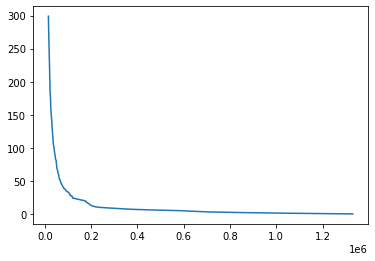

In [21]:
freqs = sorted(word_cnt.values(), reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

## Кривая Хипса

In [22]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
sum_tokens = 0
for _, row in tqdm(banki.iterrows(), total=len(banki)):
    cnt.update(row['tokens'])
    n_words.append(len(cnt))  # записываем накопленное кол-во уникальных слов для текущего твита
    sum_tokens += row['tokens_count']
    n_tokens.append(sum_tokens)  # записываем накопленное кол-во токенов ВСЕГО (включая повторения)

100%|██████████| 153499/153499 [00:20<00:00, 7553.72it/s]


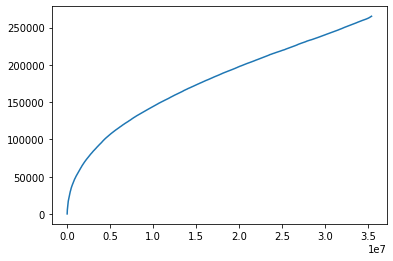

In [23]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [24]:
print('сотрудник:', lemmas_cnt['сотрудник'])
print('клиент:', lemmas_cnt['клиент'])

сотрудник: 134168
клиент: 136892


In [25]:
print('мошенничество:', lemmas_cnt['мошенничество'])
print('доверие:', lemmas_cnt['доверие'])

мошенничество: 3244
доверие: 2108


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [26]:
df = banki[pd.notna(banki['rating_grade'])][['rating_grade', 'tokens']]
df['tokens'] = df['tokens'].str.join(' ')
df

,rating_grade,tokens
14,2.0,также как и многие давний клиент банка был дов...
19,1.0,открыт вклад и счет в плюс к этому есть зарпла...
33,1.0,доброго времени вчера мне поступило смс уведом...
76,1.0,г около часов пришел в указанный офис с намере...
85,1.0,для оплаты коммунальных платежей пользуюсь пла...
...,...,...
153494,5.0,слишком большой банк не всегда учитывает нашу ...
153495,3.0,вы сами виноваты в своих проблемах кроме предп...
153496,1.0,уважаемое руководство банка овк я проживаю в г...
153497,1.0,пробовала оформить товар в кредит в альфа банк...


In [27]:
rating_texts = df.groupby('rating_grade')['tokens'].apply(lambda x: ' '.join(x))
rating_texts

rating_grade
1.0    открыт вклад и счет в плюс к этому есть зарпла...
2.0    также как и многие давний клиент банка был дов...
3.0    здравствуйте хотела написать что мне месяц не ...
4.0    несколько лет назад открывал вклады в филиале ...
5.0    досрочно закрывали вклады перед отпуском жена ...
Name: tokens, dtype: object

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
vectors = vectorizer.fit_transform(rating_texts)
vectors

<5x218755 sparse matrix of type '<class 'numpy.float64'>'
	with 484321 stored elements in Compressed Sparse Row format>

In [29]:
names = vectorizer.get_feature_names()
data = vectors.todense().tolist()

In [30]:
df = pd.DataFrame(data, columns=names, index=rating_texts.index)
df

,аа,ааа,аааа,ааааа,аааааа,ааааааа,ааааааааа,аааааааааа,ааааааааааа,аааааааааааа,...,ящичек,ящичка,ящичках,ящичке,ящичков,ящичку,ящук,яя,яяявно,яяяяясненько
rating_grade,,,,,,,,,,,,,,,,,,,,,
1.0,0.000047,0.000058,0.000029,0.000011,0.000007,0.000005,0.000000,0.000003,0.00000,0.000003,...,0.000013,0.000000,0.000003,0.000007,0.000003,0.000003,0.000003,0.000002,0.00000,0.000003
2.0,0.000046,0.000040,0.000014,0.000008,0.000000,0.000000,0.000012,0.000000,0.00000,0.000000,...,0.000034,0.000000,0.000020,0.000008,0.000000,0.000000,0.000010,0.000008,0.00000,0.000000
3.0,0.000075,0.000028,0.000000,0.000040,0.000013,0.000000,0.000000,0.000000,0.00002,0.000000,...,0.000000,0.000000,0.000000,0.000013,0.000000,0.000000,0.000000,0.000000,0.00002,0.000000
4.0,0.000175,0.000065,0.000052,0.000000,0.000031,0.000037,0.000000,0.000037,0.00000,0.000000,...,0.000026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
5.0,0.000199,0.000015,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000017,0.000016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.00000,0.000000


In [31]:
df = df[filter(lambda x: x not in stopwords_set , df.columns)]
df

,аа,ааа,аааа,ааааа,аааааа,ааааааа,ааааааааа,аааааааааа,ааааааааааа,аааааааааааа,...,ящичек,ящичка,ящичках,ящичке,ящичков,ящичку,ящук,яя,яяявно,яяяяясненько
rating_grade,,,,,,,,,,,,,,,,,,,,,
1.0,0.000047,0.000058,0.000029,0.000011,0.000007,0.000005,0.000000,0.000003,0.00000,0.000003,...,0.000013,0.000000,0.000003,0.000007,0.000003,0.000003,0.000003,0.000002,0.00000,0.000003
2.0,0.000046,0.000040,0.000014,0.000008,0.000000,0.000000,0.000012,0.000000,0.00000,0.000000,...,0.000034,0.000000,0.000020,0.000008,0.000000,0.000000,0.000010,0.000008,0.00000,0.000000
3.0,0.000075,0.000028,0.000000,0.000040,0.000013,0.000000,0.000000,0.000000,0.00002,0.000000,...,0.000000,0.000000,0.000000,0.000013,0.000000,0.000000,0.000000,0.000000,0.00002,0.000000
4.0,0.000175,0.000065,0.000052,0.000000,0.000031,0.000037,0.000000,0.000037,0.00000,0.000000,...,0.000026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
5.0,0.000199,0.000015,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000017,0.000016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.00000,0.000000


In [32]:
print('Ключевые слова в рейтингах с оценкой 1')
df.loc[1].sort_values(ascending=False)[:10]

Ключевые слова в рейтингах с оценкой 1


банка        0.158525
банк         0.120119
это          0.106830
деньги       0.082307
карту        0.061452
карты        0.056881
заявление    0.049008
отделение    0.046414
кредит       0.045110
день         0.044118
Name: 1.0, dtype: float64

In [33]:
print('Ключевые слова в рейтингах с оценкой 5')
df.loc[5].sort_values(ascending=False)[:10]

Ключевые слова в рейтингах с оценкой 5


банка     0.169528
банк      0.140131
очень     0.115927
это       0.115809
деньги    0.061830
карту     0.060633
банке     0.059105
кредит    0.054178
карты     0.050832
время     0.050751
Name: 5.0, dtype: float64

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Создаем словарь и корпус слов
### bow - bag of words (мешок слов)

In [34]:
if os.path.isfile('gensim_dict.dict'):
    gensim_dict = corpora.Dictionary.load('gensim_dict.dict')
else:
    gensim_dict = corpora.Dictionary(banki['tokens'])
    gensim_dict.save('gensim_dict.dict')
print(gensim_dict)

Dictionary(265248 unique tokens: ['а', 'адрес', 'адресе', 'банк', 'банка']...)


In [35]:
if os.path.isfile('bow_corpus.mm'):
    # Загрузка корпуса слов
    bow_corpus = corpora.MmCorpus('bow_corpus.mm')
else:
    # Если корпуса слов нет, пересчитываем (и сохраняем)
    bow_corpus = [gensim_dict.doc2bow(tokens, allow_update=True) for tokens in banki['tokens']]
    corpora.MmCorpus.serialize('bow_corpus.mm', bow_corpus)
bow_corpus[0][:10]

[(0, 2.0),
 (1, 2.0),
 (2, 1.0),
 (3, 1.0),
 (4, 1.0),
 (5, 1.0),
 (6, 1.0),
 (7, 1.0),
 (8, 1.0),
 (9, 1.0)]

## Создаем словарь и список лемм

In [36]:
list(lemmas_dict.items())[:10]

[('добрый', ('добрый', 'ADJF')),
 ('день', ('день', 'NOUN')),
 ('я', ('я', 'NPRO')),
 ('не', ('не', 'PRCL')),
 ('являюсь', ('являться', 'VERB')),
 ('клиентом', ('клиент', 'NOUN')),
 ('банка', ('банк', 'NOUN')),
 ('и', ('и', 'CONJ')),
 ('поручителем', ('поручитель', 'NOUN')),
 ('по', ('по', 'PREP'))]

In [37]:
def get_lemmas_texts():
    pos_list = ['NOUN', 'ADJF', 'ADJS', 'NPRO']

    lemmas_texts = []
    for i, doc in enumerate(tqdm(bow_corpus)):
        lemmas_texts.append([])
        for word_id, count in doc:
            word = gensim_dict[word_id]
            lemma, pos = lemmas_dict[word]
            if word not in stopwords_set and pos in pos_list:
                lemmas_texts[i].extend([lemma] * int(count))
    return lemmas_texts

lemmas_texts = None

In [38]:
if os.path.isfile('gensim_lemmas_dict.dict'):
    gensim_lemmas_dict = corpora.Dictionary.load('gensim_lemmas_dict.dict')
else:
    if lemmas_texts is None:
        lemmas_texts = get_lemmas_texts()
    gensim_lemmas_dict = corpora.Dictionary(lemmas_texts)
    gensim_lemmas_dict.save('gensim_lemmas_dict.dict')
print(gensim_lemmas_dict)

Dictionary(67700 unique tokens: ['адрес', 'банк', 'бесконечный', 'ваш', 'весь']...)


In [39]:
if os.path.isfile('bow_lemmas_corpus.mm'):
    # Загрузка корпуса лемм
    bow_lemmas_corpus = corpora.MmCorpus('bow_lemmas_corpus.mm')
else:
    # Если корпуса лемм нет, пересчитываем (и сохраняем)
    if lemmas_texts is None:
        lemmas_texts = get_lemmas_texts()
    bow_lemmas_corpus = [gensim_lemmas_dict.doc2bow(tokens, allow_update=True) for tokens in lemmas_texts]
    corpora.MmCorpus.serialize('bow_lemmas_corpus.mm', bow_lemmas_corpus)
bow_lemmas_corpus[0][:10]

[(0, 3.0),
 (1, 3.0),
 (2, 1.0),
 (3, 1.0),
 (4, 1.0),
 (5, 1.0),
 (6, 1.0),
 (7, 1.0),
 (8, 2.0),
 (9, 1.0)]

## Создание модели темы LDA

In [40]:
from gensim.models import LdaMulticore

if os.path.isfile('lda_model.model'):
    lda_model = LdaMulticore.load('lda_model.model')
else:
    lda_model = LdaMulticore(
        corpus=bow_lemmas_corpus,
        id2word=gensim_lemmas_dict,
        random_state=100,
        num_topics=7,
        passes=10,
        chunksize=1000,
        batch=False,
        alpha='asymmetric',
        decay=0.5,
        offset=64,
        eta=None,
        eval_every=0,
        iterations=100,
        gamma_threshold=0.001,
        per_word_topics=True
    )
    lda_model.save('lda_model.model')

lda_model.print_topics(-1)

[(0,
  '0.046*"деньга" + 0.032*"банк" + 0.025*"банкомат" + 0.023*"счёт" + 0.021*"карта" + 0.020*"сбербанк" + 0.019*"день" + 0.017*"заявление" + 0.017*"отделение" + 0.017*"мой"'),
 (1,
  '0.045*"банк" + 0.017*"клиент" + 0.017*"отделение" + 0.013*"офис" + 0.012*"сотрудник" + 0.011*"очередь" + 0.011*"время" + 0.011*"который" + 0.011*"день" + 0.010*"документ"'),
 (2,
  '0.017*"дверь" + 0.016*"машина" + 0.007*"ты" + 0.007*"дом" + 0.007*"магазин" + 0.006*"голос" + 0.006*"ребёнок" + 0.006*"улица" + 0.006*"жизнь" + 0.005*"охранник"'),
 (3,
  '0.087*"карта" + 0.049*"банк" + 0.011*"кредитный" + 0.011*"день" + 0.010*"который" + 0.009*"интернет" + 0.009*"мой" + 0.009*"отделение" + 0.009*"клиент" + 0.009*"год"'),
 (4,
  '0.057*"кредит" + 0.046*"банк" + 0.031*"договор" + 0.030*"сумма" + 0.017*"кредитный" + 0.016*"платёж" + 0.013*"погашение" + 0.012*"год" + 0.012*"руб" + 0.011*"страховка"'),
 (5,
  '0.063*"вклад" + 0.061*"банк" + 0.032*"счёт" + 0.024*"комиссия" + 0.022*"сумма" + 0.021*"перевод" + 0.0

In [41]:
for c in lda_model[bow_lemmas_corpus[5:8]]:
    print("Document Topics      : ", c[0])      # [(Topics, Perc Contrib)]
    print("Word id, Topics      : ", c[1][:3])  # [(Word id, [Topics])]
    print("Phi Values (word id) : ", c[2][:2])  # [(Word id, [(Topic, Phi Value)])]
    print("Word, Topics         : ", [(gensim_lemmas_dict[wd], topic) for wd, topic in c[1][:2]])   # [(Word, [Topics])]
    print("Phi Values (word)    : ", [(gensim_lemmas_dict[wd], topic) for wd, topic in c[2][:2]])  # [(Word, [(Topic, Phi Value)])]
    print("------------------------------------------------------\n")

Document Topics      :  [(2, 0.06788778), (4, 0.44055572), (5, 0.10143923), (6, 0.36940637)]
Word id, Topics      :  [(1, [6, 4, 5]), (3, [6, 4, 5]), (19, [4, 6, 5])]
Phi Values (word id) :  [(1, [(4, 0.41848737), (5, 0.11012478), (6, 0.46990222)]), (3, [(4, 0.1572872), (5, 0.021791391), (6, 0.8125499)])]
Word, Topics         :  [('банк', [6, 4, 5]), ('ваш', [6, 4, 5])]
Phi Values (word)    :  [('банк', [(4, 0.41848737), (5, 0.11012478), (6, 0.46990222)]), ('ваш', [(4, 0.1572872), (5, 0.021791391), (6, 0.8125499)])]
------------------------------------------------------

Document Topics      :  [(0, 0.19457643), (3, 0.7846913)]
Word id, Topics      :  [(1, [3, 0]), (28, [3, 0]), (44, [3, 0])]
Phi Values (word id) :  [(1, [(0, 0.26283845), (3, 1.7368317)]), (28, [(0, 0.35111278), (3, 0.64886844)])]
Word, Topics         :  [('банк', [3, 0]), ('заявление', [3, 0])]
Phi Values (word)    :  [('банк', [(0, 0.26283845), (3, 1.7368317)]), ('заявление', [(0, 0.35111278), (3, 0.64886844)])]
----

In [42]:
from gensim.models import LsiModel

if os.path.isfile('lsi_model.model'):
    lsi_model = LsiModel.load('lsi_model.model')
else:
    lsi_model = LsiModel(
        corpus=bow_lemmas_corpus,
        id2word=gensim_lemmas_dict,
        num_topics=7,
        decay=0.5
    )
    lsi_model.save('lsi_model.model')

lsi_model.print_topics(-1)

[(0,
  '0.662*"банк" + 0.318*"карта" + 0.168*"деньга" + 0.157*"день" + 0.151*"который" + 0.151*"кредит" + 0.148*"мой" + 0.142*"счёт" + 0.137*"отделение" + 0.137*"клиент"'),
 (1,
  '-0.857*"карта" + 0.361*"банк" + 0.229*"кредит" + 0.092*"договор" + 0.081*"документ" + -0.078*"заявление" + -0.078*"банкомат" + -0.075*"отделение" + 0.056*"вклад" + 0.054*"платёж"'),
 (2,
  '0.539*"деньга" + -0.362*"банк" + 0.311*"счёт" + -0.273*"карта" + 0.244*"банкомат" + 0.235*"отделение" + -0.221*"кредит" + 0.141*"вклад" + -0.137*"кредитный" + 0.135*"день"'),
 (3,
  '0.660*"кредит" + -0.453*"банк" + 0.197*"сумма" + 0.195*"день" + -0.187*"вклад" + 0.172*"кредитный" + 0.125*"платёж" + 0.118*"документ" + 0.116*"месяц" + 0.104*"заявление"'),
 (4,
  '0.402*"отделение" + -0.369*"деньга" + -0.332*"счёт" + 0.229*"клиент" + -0.204*"сумма" + -0.191*"банкомат" + 0.190*"вклад" + 0.172*"очередь" + -0.153*"банк" + 0.146*"документ"'),
 (5,
  '0.592*"счёт" + -0.352*"деньга" + -0.338*"банкомат" + -0.290*"вклад" + -0.206*"

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 